In [ ]:
!pip install wandb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import wandb

# Initialize Weights and Biases (optional)
wandb.init(project="optimizer-analysis")

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()


In [ ]:
# Choose optimizer here and parameters
optimizers = {
    "SGD": optim.SGD(model.parameters(), lr=0.1),
    "SGD_with_momentum": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    "Adagrad": optim.Adagrad(model.parameters(), lr=0.01),
    "Adam": optim.Adam(model.parameters(), lr=0.001)
}


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return avg_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy


In [ ]:
def run_experiments():
    epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}

    for name, optimizer in optimizers.items():
        model = SimpleNN().to(device)
        optimizer = optimizer

        train_losses = []
        test_accuracies = []

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
            test_loss, test_acc = test(model, device, test_loader)

            train_losses.append(train_loss)
            test_accuracies.append(test_acc)

            wandb.log({
                "epoch": epoch,
                f"train_loss_{name}": train_loss,
                f"train_accuracy_{name}": train_acc,
                f"test_accuracy_{name}": test_acc
            })
            print(f"Optimizer: {name}, Epoch: {epoch}, Train Loss: {train_loss}, Test Accuracy: {test_acc}")

        results[name] = {
            "train_loss": train_losses,
            "test_accuracy": test_accuracies
        }

    return results


Optimizer: SGD, Epoch: 1, Train Loss: 2.3056257210814874, Test Accuracy: 7.92
Optimizer: SGD, Epoch: 2, Train Loss: 2.3056228641253798, Test Accuracy: 7.92
Optimizer: SGD, Epoch: 3, Train Loss: 2.3056181262551085, Test Accuracy: 7.92
Optimizer: SGD, Epoch: 4, Train Loss: 2.3056435429973643, Test Accuracy: 7.92
Optimizer: SGD, Epoch: 5, Train Loss: 2.3056369656438767, Test Accuracy: 7.92
Optimizer: SGD_with_momentum, Epoch: 1, Train Loss: 2.3042540611234554, Test Accuracy: 8.5
Optimizer: SGD_with_momentum, Epoch: 2, Train Loss: 2.3042405381131528, Test Accuracy: 8.5
Optimizer: SGD_with_momentum, Epoch: 3, Train Loss: 2.3042494320411926, Test Accuracy: 8.5
Optimizer: SGD_with_momentum, Epoch: 4, Train Loss: 2.3042577070468018, Test Accuracy: 8.5
Optimizer: SGD_with_momentum, Epoch: 5, Train Loss: 2.3042509944708365, Test Accuracy: 8.5
Optimizer: Adagrad, Epoch: 1, Train Loss: 2.3111295316265084, Test Accuracy: 9.91
Optimizer: Adagrad, Epoch: 2, Train Loss: 2.3111472422126007, Test Accura

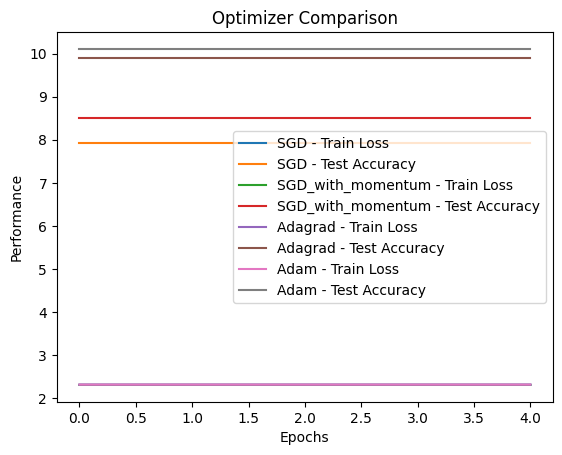

In [ ]:
def plot_results(results):
    for name, result in results.items():
        plt.plot(result['train_loss'], label=f"{name} - Train Loss")
        plt.plot(result['test_accuracy'], label=f"{name} - Test Accuracy")

    plt.title("Optimizer Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Performance")
    plt.legend()
    plt.show()

# Run experiments and plot
results = run_experiments()
plot_results(results)
